## This notebook demonstrates the usage of SIDMpy, a python package to compute the central density of SIDM halos using a simple Jeans argument presented by Kaplinghat et al. 2016

In [1]:
from sidmpy.sidmpy import solve_from_NFW_params
import matplotlib.pyplot as plt

plt.rcParams['axes.linewidth'] = 2.5
plt.rcParams['xtick.major.width'] = 2.5
plt.rcParams['xtick.major.size'] = 6
plt.rcParams['xtick.minor.size'] = 4
plt.rcParams['ytick.major.width'] = 2.5
plt.rcParams['ytick.major.size'] = 6
plt.rcParams['ytick.minor.size'] = 4
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['xtick.labelsize'] = 15

To start we'll assume a functional form for the SIDM cross section given by 

\begin{equation}
\sigma\left(v\right) = \sigma_0 \left(1 + \frac{v^2}{v_0^2}\right)^{-2}
\end{equation}

The name of the cross section implemented for the parameterization is TCHANNEL. In the above equation, the velocity $v$ is the relative speed of two SIDM particles, which we could reasonably equate with the central velocity dispersion of the SIDM halo. We don't know this a-priori, but we can compute it simultaneously with the central density of the isothermal part of the halo. Other cross section parmerizations are POWER_LAW and VELOCITY_INDEPENDENT. 

In the cell below, we'll compute the central density of a cored halo $\rho_0$ using the prescription first described by Kaplinghat et al. 2016. 

In [2]:
# specify the parameters describing an NFW halo: density normalization, scale radius, and the age of the halo
# units: M_sun / kpc^3, kpc, Gyr
rhos, rs, halo_age = 50062409, 0.617, 10.
cross_section_type = 'TCHANNEL'
# specify the normalization of the cross section at v_ref [cm^2/gram]
cross_norm = 6.
# specify the velocity dependence of the cross section 
v_dep = 0.8
v_ref = 10 
kwargs_cross_section = {'norm': cross_norm, 'v_ref': v_ref}
rho_core, velocity_dispersion, r_1 = solve_from_NFW_params(rhos, rs, halo_age, cross_section_type, kwargs_cross_section,
                                                     plot=False)
print('solution found:', rho_core, velocity_dispersion)

solution found: 216036021.1184006 8.698812515250681


### Now we can plot the profile

We'll compare the isothermal solution to an NFW profile and a cored NFW profile

\begin{equation}
\rho\left(r, r_c, r_s\right) = \frac{\rho_s}{\left(x^a + \beta^a\right)^{\frac{1}{a}}\left(1+x\right)^2}
\end{equation}

where $\beta = \frac{r_c}{r_s} = \frac{\rho_0}{\rho_s}$ and $x = \frac{r}{r_s}$. The parameter $a$ sets how rapidly the profile transiations from cored to NFW-like. Larger values of $a$ seem to be better matches to the density profiels of SIDM halos in simulations, however, the only value for which analytic solutions exist for the deflection angle is $a=1$. Below, we'll set $a=10$. 

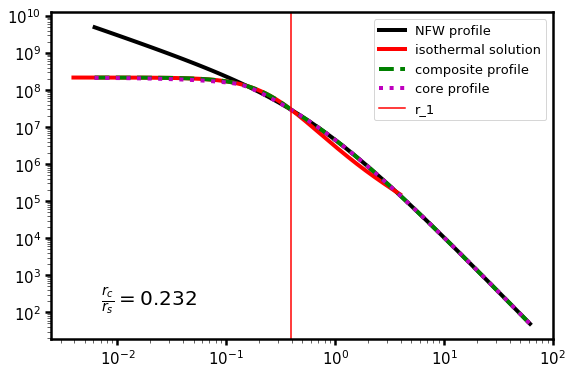

In [24]:
from sidmpy.Profiles.sidm_profile import SIDMprofile
from sidmpy.Profiles.nfw_like import TNFWprofile, coreTNFWprofile
import numpy as np

prof = SIDMprofile(rho_core, velocity_dispersion, r_1, rhos, rs, xmin=0.01, xmax=10)
#prof = SIDMprofile.fromNFWparams(rhos, rs, halo_age, cross_section_type, kwargs_cross_section, xmin=0.01, xmax=10)
r = np.logspace(-2, 2, 100) * rs
density_composite = prof(r, smooth=True, smooth_scale=0.1)

rt = 1e+6 * rs
rc = rhos * rs / rho_core
density_nfw = TNFWprofile(r, rhos, rs, rt)
density_isothermal = prof.rho_isothermal
density_approx = coreTNFWprofile(r, rhos, rs, rt, rc, a=10)
fig = plt.figure(1)
fig.set_size_inches(9,6)
plt.loglog(r, density_nfw, color='k', label='NFW profile', lw=4)
plt.loglog(prof.r_iso, prof.rho_isothermal, color='r', label='isothermal solution', lw=4)
plt.loglog(r, density_composite, color='g', linestyle='--', label='composite profile', lw=4)
plt.loglog(r, density_approx, color='m', linestyle=':', label='core profile', lw=4)
plt.axvline(r_1, color='r', label='r_1')
plt.annotate(r'$\frac{r_c}{r_s} = $'+str(np.round(rc/rs, 3)), xy=(0.1, 0.1), xycoords='axes fraction', fontsize=20)
plt.legend(fontsize=13)


### Core collapse

Heat trasnfer due to self interactions can lead to core collapse of SIDM halos, particularly at high cross sections. This process can be accelerated if the halos reside in a tidal field. 

In [ ]:
from sidmpy.CrossSections.power_law import PowerLaw
from sidmpy.core_collapse_timescale import evolution_timescale
from pyHalo.Halos.lens_cosmo import LensCosmo
lc = LensCosmo()
M = 10**8.
z = 0.5
c = lc.NFW_concentration(M, z, scatter=False)
rhos, rs, _ = lc.NFW_params_physical(M, c, z)

cross_norm = 5.
kwargs_cross_section = {'norm': cross_norm, 'v_ref': 30, 'v_dep': 0.9}
cross = PowerLaw(**kwargs_cross_section)
velocity_averaged_cross_section = cross.maxwell_boltzmann_average(1.)
print(velocity_averaged_cross_section)

t0 = evolution_timescale(rhos, rs, velocity_averaged_cross_section)
print(50 * t0)

## Interpolated solutions

solutions for the central core density are pre-computed and saved for a subset of possible cross section models 

In [ ]:
from sidmpy.sidmpy import solve_with_interpolation
from sidmpy.sidmpy import solve_from_Mz

cross_section_type = 'TCHANNEL'
kwargs_cross_section = {'norm': 6., 'v_ref': 10.}
rho0_from_interp = solve_with_interpolation(10 ** 7.5, 0.6, 0., cross_section_type, kwargs_cross_section)
rho0_exact_solution = solve_from_Mz(10**7.5, 0.6, cross_section_type, kwargs_cross_section)[0]
print(rho0_from_interp/rho0_exact_solution)

In [ ]:
from sidmpy.sidmpy import solve_with_interpolation
from sidmpy.sidmpy import solve_from_Mz

c_scatter_dex = 0.1
cross_section_type = 'TCHANNEL'
kwargs_cross_section = {'norm': 9., 'v_ref': 10.}
kwargs_interp = {'concentration_scatter_scale': 0.8}
rho0_exact_with_scatter = solve_from_Mz(10**7.5, 0.6, cross_section_type, kwargs_cross_section, 
                                         c_scatter_add_dex=c_scatter_dex)[0]
rho0_from_interp = solve_with_interpolation(10 ** 7.5, 0.6, c_scatter_dex, cross_section_type, 
                                            kwargs_cross_section, kwargs_interp)
print(rho0_from_interp/rho0_exact_with_scatter)

In [ ]:
from sidmpy.sidmpy import solve_with_interpolation
from sidmpy.sidmpy import solve_from_Mz

c_scatter_dex = 0.
cross_section_type = 'POWER_LAW'
kwargs_cross_section = {'norm': 9., 'v_ref': 30., 'v_dep': 0.4}
kwargs_interp = {'concentration_scatter_scale': 0.85}
rho0_exact_with_scatter = solve_from_Mz(10**7.5, 0.6, cross_section_type, kwargs_cross_section, 
                                          c_scatter_add_dex=c_scatter_dex)[0]
rho0_from_interp = solve_with_interpolation(10 ** 7.5, 0.6, c_scatter_dex, cross_section_type, 
                                            kwargs_cross_section, kwargs_interp)
print(rho0_from_interp/rho0_exact_with_scatter)

In [ ]:
print(rho0_from_interp)